In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [15]:
import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning

# import os
# os.environ["NUMBA_DISABLE_JIT"] = "0"
# os.environ["NUMBA_DEVELOPER_MODE"] = "1"

import numpy as np
import matplotlib
from matplotlib import pylab

from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.initialisation.spectra import Sum
from PySDM.physics import si

from atmos_cloud_sim_uj_utils import show_plot

from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark

In [35]:
consts = {
    "MAC":1,
    "HAC":1,
    "BDF":False
    }

output = {}

lines = {'Constant': '-', 'CompressedFilmOvadnevaite': '--', 'SzyszkowskiLangmuir': '-.', 'CompressedFilmRuehl': ':'}
colors = {'Constant': 'k', 'CompressedFilmOvadnevaite': 'C0', 'CompressedFilmRuehl': 'C1', 'SzyszkowskiLangmuir': 'C2'}

aerosol = AerosolBetaCaryophylleneDark()
for model in ('Constant', 'CompressedFilmOvadnevaite', 'SzyszkowskiLangmuir', 'CompressedFilmRuehl'):
    print(model)
    key = f"{aerosol.__class__.__name__}-{model}"
    settings = Settings(
        dz=1*si.m,
        n_sd_per_mode=200, 
        model=model,
        aerosol=aerosol,
        spectral_sampling=spec_sampling.ConstantMultiplicity,
        **consts
    )
    simulation = ParcelSimulation(settings)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=NumbaExperimentalFeatureWarning)
        output[key] = simulation.run()
    output[key]['color'] = colors[model]
    output[key]['linestyle'] = lines[model]
    output[key]['Na_tot'] = Sum(
        tuple(settings.aerosol.modes[i]['spectrum']
                for i in range(len(settings.aerosol.modes)))).norm_factor

Constant
CompressedFilmOvadnevaite
SzyszkowskiLangmuir


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<numba._DUFunc 'sigma'>) found for signature:
 
 >>> sigma(float64, v_wet=float64, v_dry=float64, f_org=float64)
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'DUFunc._type_me': File: numba/np/ufunc/dufunc.py: Line 264.
      With argument(s): '(float64, v_wet=float64, v_dry=float64, f_org=float64)':
     Rejected as the implementation raised a specific error:
       AssertionError: 
  raised from /Users/claresinger/anaconda3/envs/pysdm/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:272

During: resolving callee type: Function(<numba._DUFunc 'sigma'>)
During: typing of call at /Users/claresinger/Research/PySDM/PySDM/initialisation/equilibrate_wet_radii.py (48)


File "../../../PySDM/PySDM/initialisation/equilibrate_wet_radii.py", line 48:
    def minfun(r, T, RH, kp, rd3, f_org):  # pylint: disable=too-many-arguments
        sgm = sigma(
        ^

During: resolving callee type: type(CPUDispatcher(<function equilibrate_wet_radii.<locals>.minfun at 0x7fca7be44b80>))
During: typing of call at /Users/claresinger/Research/PySDM/PySDM/initialisation/equilibrate_wet_radii.py (86)

During: resolving callee type: type(CPUDispatcher(<function equilibrate_wet_radii.<locals>.minfun at 0x7fca7be44b80>))
During: typing of call at /Users/claresinger/Research/PySDM/PySDM/initialisation/equilibrate_wet_radii.py (91)

During: resolving callee type: type(CPUDispatcher(<function equilibrate_wet_radii.<locals>.minfun at 0x7fca7be44b80>))
During: typing of call at /Users/claresinger/Research/PySDM/PySDM/initialisation/equilibrate_wet_radii.py (86)


File "../../../PySDM/PySDM/initialisation/equilibrate_wet_radii.py", line 86:
    def r_wet_init_impl(  # pylint: disable=too-many-arguments,too-many-locals
        <source elided>

            fa = minfun(a, *args)
            ^


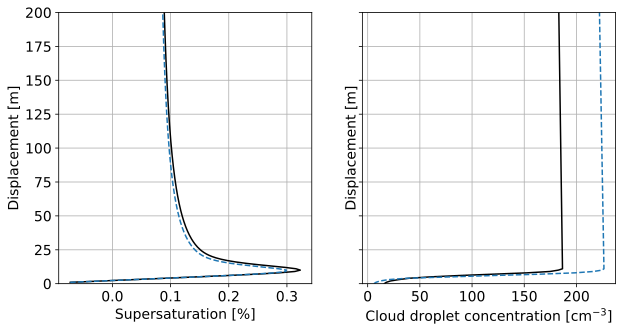

HTML(value="<a href='./CliMA_review_fig2.pdf' target='_blank'>./CliMA_review_fig2.pdf</a><br>")

In [17]:
figsize = (10, 5)
pylab.rc('font', size=14)
fig, axs = pylab.subplots(1, 2, figsize=figsize, sharey=True)

dat = np.zeros((len(output[key]['z']), 5))
i = 1

for idx, var in enumerate(('S_max', 'n_c_cm3')):
    for key, output_k in output.items():
        Y = np.asarray(output_k['z'])
        axs[idx].plot(output_k[var], Y, label=key.split("-")[-1], 
                      color=output_k['color'],
                      linestyle=output_k['linestyle']
                     )
        dat[:,0] = Y
        dat[:,i] = output_k[var]
        i += 1
    axs[idx].set_ylim(0, 200)
    
    axs[idx].set_ylabel('Displacement [m]')
    if var == 'S_max':
        axs[idx].set_xlabel('Supersaturation [%]')
        # axs[idx].set_xlim(0, 0.5)
    elif var == 'n_c_cm3':
        axs[idx].set_xlabel('Cloud droplet concentration [cm$^{-3}$]')
        # axs[idx].set_xlim(0, 250)
    else:
        assert False
    
for ax in axs:
    ax.grid()
axs[0].legend()
pylab.show()

# print(dat)
# np.savetxt("Ryan_parcel.csv", dat, delimiter=',', fmt='%.4f', 
#            header='z (m), SS (bulk), SS (film), CDNC (bulk) (cm-3), CDNC (film) (cm-3)')

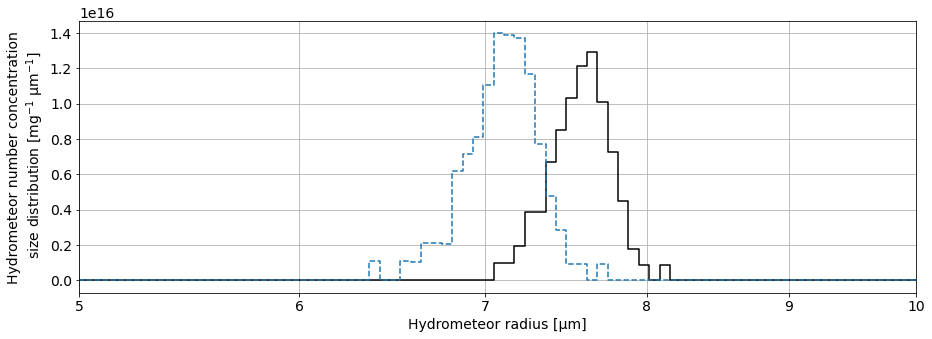

In [14]:
dat = np.zeros((len(settings.wet_radius_bins_edges[:-1]), 3))
dat[:,0] = settings.wet_radius_bins_edges[:-1]
i = 1

record_number = -1
figsize = (15, 5)
pylab.rc('font', size=14)
fig, axs = pylab.subplots(1, 1, figsize=figsize, sharey=True)
for key, output_k in output.items():
    pylab.step(
        settings.wet_radius_bins_edges[:-1] / si.um,
        output_k['spectrum'],
        label=f'wet ({key})',
        color=output_k['color'],
        linestyle=output_k['linestyle'],
        where='pre'
    )
    dat[:,i] = output_k['spectrum']
    i +=1
pylab.xscale('log')
pylab.grid()
pylab.xlabel("Hydrometeor radius [μm]")
pylab.ylabel("Hydrometeor number concentration\n size distribution [mg$^{-1}$ μm$^{-1}$]")
xticks = (5,6,7,8,9,10)
#xticks = (8,9,10,11,12)
axs.set_xticks(xticks)
axs.set_xlim(xticks[0], xticks[-1])
axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
pylab.show()

# print(dat)
# np.savetxt("Ryan_parcel_sizedist.csv", dat, delimiter=',', fmt='%.4e', header='r_wet (m), Nc (bulk), Nc (film)')

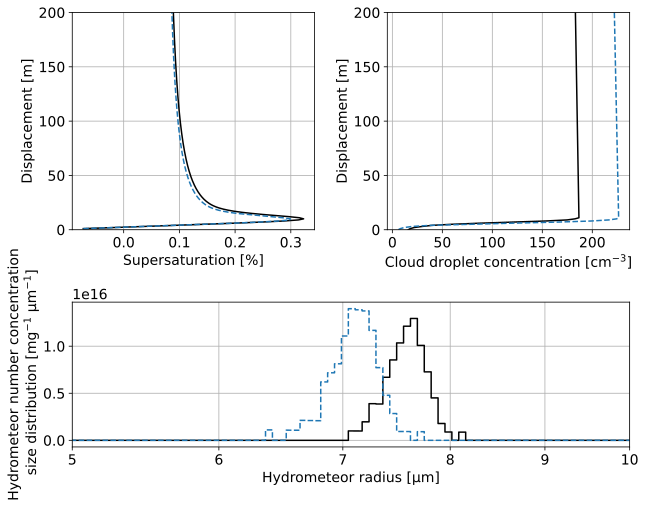

HTML(value="<a href='./CliMA_review_fig2.pdf' target='_blank'>./CliMA_review_fig2.pdf</a><br>")

In [34]:
figsize = (10, 8)
pylab.rc('font', size=14)

fig = pylab.figure(constrained_layout=False, figsize=figsize)
gs1 = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[3,2], wspace=0.3, hspace=0.4)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[1,:])
axs = [ax1, ax2]

dat = np.zeros((len(output[key]['z']), 5))
i = 1

for idx, var in enumerate(('S_max', 'n_c_cm3')):
    for key, output_k in output.items():
        Y = np.asarray(output_k['z'])
        axs[idx].plot(output_k[var], Y, label=key.split("-")[-1], 
                      color=output_k['color'],
                      linestyle=output_k['linestyle']
                     )
        dat[:,0] = Y
        dat[:,i] = output_k[var]
        i += 1
    axs[idx].set_ylim(0, 200)
    
    axs[idx].set_ylabel('Displacement [m]')
    if var == 'S_max':
        axs[idx].set_xlabel('Supersaturation [%]')
        # axs[idx].set_xlim(0, 0.5)
    elif var == 'n_c_cm3':
        axs[idx].set_xlabel('Cloud droplet concentration [cm$^{-3}$]')
        # axs[idx].set_xlim(0, 250)
    else:
        assert False
    
for ax in axs:
    ax.grid()

#######################

dat = np.zeros((len(settings.wet_radius_bins_edges[:-1]), 3))
dat[:,0] = settings.wet_radius_bins_edges[:-1]
i = 1

record_number = -1
for key, output_k in output.items():
    ax3.step(
        settings.wet_radius_bins_edges[:-1] / si.um,
        output_k['spectrum'],
        label=f'wet ({key})',
        color=output_k['color'],
        linestyle=output_k['linestyle'],
        where='pre'
    )
    dat[:,i] = output_k['spectrum']
    i +=1
ax3.set_xscale('log')
ax3.grid()
ax3.set_xlabel("Hydrometeor radius [μm]")
ax3.set_ylabel("Hydrometeor number concentration\n size distribution [mg$^{-1}$ μm$^{-1}$]")
xticks = (5,6,7,8,9,10)
ax3.set_xticks(xticks)
ax3.set_xlim(xticks[0], xticks[-1])
ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

show_plot("CliMA_review_fig2.pdf")